In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import torch
from kan import KAN
import time
import sympy as sp
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
def root_mean_square_percentage_error(pred, true):
    if not torch.is_tensor(pred):
        pred = torch.tensor(pred, dtype=torch.float32)
    if not torch.is_tensor(true):
        true = torch.tensor(true, dtype=torch.float32)
    percentage_errors = (true - pred) / true
    return torch.sqrt(torch.mean(percentage_errors ** 2))

In [3]:
DATA_PATH = './data/'
WEEL_INFO = 'wear_data_train.csv'
SERVICE_INFO = 'service_dates.csv'
start_date = '2023-01-01'
end_date = '2025-09-30'
target = 'wear_intensity'

In [4]:
df = pd.read_csv(DATA_PATH + 'dataset.csv')

In [5]:
df = df.dropna(subset=[target])

df = df[[
    'locomotive_series',
    'locomotive_number',
    'depo',
    'directorate',
    'steel_num',
    'mileage_start',
    'total_service_type_4',
    target
]]

df = df.dropna()


In [6]:
X = df.drop(columns=[target])
y = df[target]

for col in X.columns:
    if X[col].nunique() / len(X) > 0.95:
        print(f"Удаляем признак {col} (слишком много уникальных значений)")
        X = X.drop(columns=[col])

In [7]:
categorical_features = X.select_dtypes(include=['object', 'string']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print('Категориальные после очистки:', categorical_features)
print('Числовые после очистки:', numeric_features)

Категориальные после очистки: ['locomotive_series', 'depo', 'directorate']
Числовые после очистки: ['locomotive_number', 'steel_num', 'mileage_start', 'total_service_type_4']


In [8]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
#     ])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    le.fit(X_train[col].astype(str))
    X_train[col] = le.transform(X_train[col].astype(str))
    def encode_test(x):
        try:
            return le.transform([x])[0]
        except ValueError:
            return -1
    X_test[col] = X_test[col].astype(str).apply(encode_test)
    label_encoders[col] = le

In [11]:
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [12]:
train_input = torch.tensor(X_train.values, dtype=torch.float32)
train_label = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

test_input = torch.tensor(X_test.values, dtype=torch.float32)
test_label = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

kan_dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

print(f"Размерность train_input: {train_input.shape}")
print(f"Количество признаков после обработки: {train_input.shape[1]}")

Размерность train_input: torch.Size([323048, 7])
Количество признаков после обработки: 7


In [13]:
# df_encoded = df.copy()
# label_encoders = {}
# for cat_feat in categorical_features:
#     le = LabelEncoder()
#     df_encoded[cat_feat] = le.fit_transform(df_encoded[cat_feat].astype(str))
#     label_encoders[cat_feat] = le

In [14]:
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

In [15]:
# X = df_encoded.drop(columns=[target])
# y = df_encoded[[target]]

# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y).flatten()

# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_scaled, test_size=0.2, random_state=42
# )

# print(f"Train: {X_train.shape}, Test: {X_test.shape}")
# print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [16]:
# def get_kan_dataset(data, features=[]):
#     if not features:
#         features = list(range(data['Xtest'].shape[1]))
#     train_input = torch.tensor(data['Xtrain'][:, features], dtype=torch.float32)
#     train_label = torch.tensor(data['Ytrain'], dtype=torch.float32).unsqueeze(1)
#     test_input = torch.tensor(data['Xtest'][:, features], dtype=torch.float32)
#     test_label = torch.tensor(data['Ytest'], dtype=torch.float32).unsqueeze(1)
#     return {
#         'train_input': train_input,
#         'train_label': train_label,
#         'test_input': test_input,
#         'test_label': test_label
#     }
# kan_dataset = get_kan_dataset({
#     'Xtrain': X_train,
#     'Ytrain': y_train,
#     'Xtest': X_test,
#     'Ytest': y_test
# })

In [ ]:
first_layer = kan_dataset['train_input'].shape[1]
print('Количество нейронов во входном слое:', first_layer)
second_layer = first_layer * 2 + 1
print('Количество нейронов во втором слое:', second_layer)
output_layer = 1
print('Количество выходов:', output_layer)
model = KAN(width=[first_layer, output_layer], seed=42)
print(model)
def test_r2():
    pred = model(kan_dataset['test_input']).detach().numpy()
    return torch.tensor(r2_score(kan_dataset['test_label'].numpy(), pred))
def test_rmspe():
    pred = model(kan_dataset['test_input']).detach()
    true = kan_dataset['test_label']
    return root_mean_square_percentage_error(pred, true)
start = time.time()
results = model.fit(
    kan_dataset,
    opt="LBFGS",
    steps=500,
    loss_fn=torch.nn.MSELoss(),
    metrics=[test_r2, test_rmspe],
    display_metrics=['train_loss', 'test_loss', 'test_r2', 'test_rmspe'],
)
fit_time = time.time() - start
test_preds = model.forward(kan_dataset['test_input']).detach()
test_labels = kan_dataset['test_label'].numpy()
print('\nОбучение KAN завершилось')
print("   Test R2 Score:", r2_score(test_labels, test_preds.numpy()))
print("   Test RMSPE:", root_mean_square_percentage_error(test_labels, test_preds.numpy()).item())
print('   Время обучения:', fit_time)

Количество нейронов во входном слое: 7
Количество нейронов во втором слое: 15
Количество выходов: 1
checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)


 train_loss: 4.96e-01 | test_loss: 4.95e-01 | test_r2: -7.15e-02 | test_rmspe: 7.99e-01 |: 100%|█| 2

saving model version 0.1

Обучение KAN завершилось
   Test R2 Score: -0.07154583930969238
   Test RMSPE: 0.6982647776603699
   Время обучения: 25.048297882080078


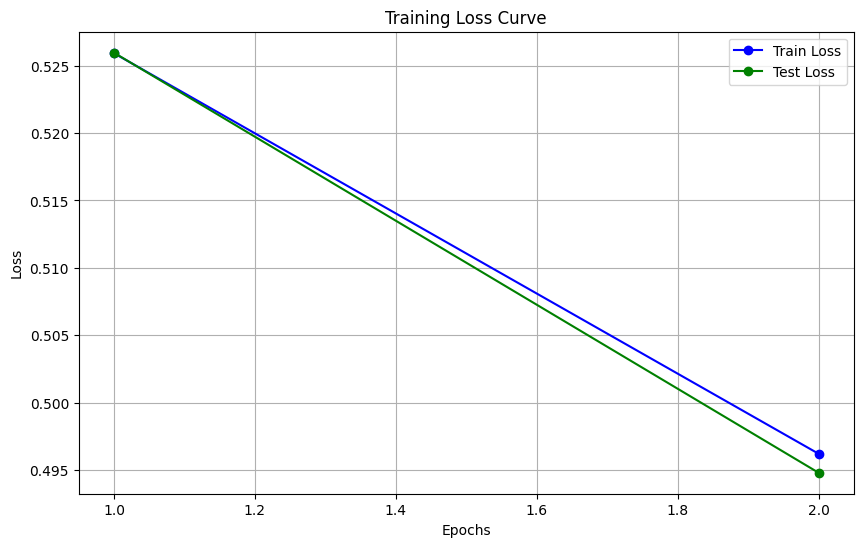

In [18]:
def plot_KANfit_progress(fit_results):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(fit_results['train_loss']) + 1), fit_results['train_loss'], marker='o', color='b', label='Train Loss')
    plt.plot(range(1, len(fit_results['test_loss']) + 1), fit_results['test_loss'], marker='o', color='g', label='Test Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('grp_' + plt.gca().get_title() + '.png')
plot_KANfit_progress(results)

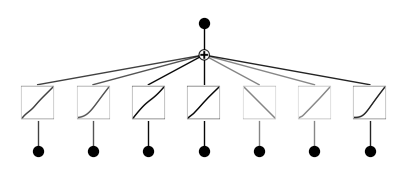

In [19]:
model.plot()

In [20]:
model_pruned = model.prune()

saving model version 0.2


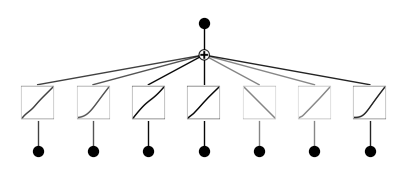

In [21]:
model_pruned.plot()

In [22]:
train_pred = model(train_input).detach().numpy()
test_pred = model(test_input).detach().numpy()

y_train_orig = train_label.numpy()
y_test_orig = test_label.numpy()

train_pred = train_pred.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)
y_train_orig = y_train_orig.reshape(-1, 1)
y_test_orig = y_test_orig.reshape(-1, 1)

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("R2 на train:", r2_score(y_train_orig, train_pred))
print("R2 на test:", r2_score(y_test_orig, test_pred))
print("MAE на test:", mean_absolute_error(y_test_orig, test_pred))
print("RMSE на test:", np.sqrt(mean_squared_error(y_test_orig, test_pred)))

R2 на train: -0.07217872142791748
R2 на test: -0.07154583930969238
MAE на test: 0.3584766089916229
RMSE на test: 0.4947954144252253


In [24]:
start = time.time()
lib = ['x', 'x^2', 'exp', 'sqrt']
model.auto_symbolic(lib=lib)
formula = sp.sympify(str(model.symbolic_formula()[0][0]))
print('Получение формулы заняло:', time.time() - start)
print('Формула:')
print('    ', formula)

fixing (0,0,0) with x, r2=0.997920572757721, c=1
fixing (0,1,0) with x, r2=0.9318634271621704, c=1
fixing (0,2,0) with x, r2=0.9963272213935852, c=1
fixing (0,3,0) with x, r2=0.9985915422439575, c=1
fixing (0,4,0) with x, r2=0.9999931454658508, c=1
fixing (0,5,0) with x, r2=0.9641663432121277, c=1
fixing (0,6,0) with x^2, r2=0.9918288588523865, c=2
saving model version 0.2
Получение формулы заняло: 464.3130888938904
Формула:
     0.00208359821330832*x_1 + 0.0351042362081184*x_2 + 0.00238662698358705*x_3 + 0.0705227924136187*x_4 - 0.0202826555135827*x_5 + 0.0223134515675447*x_6 + 0.00050188135355711*(-5.11143970489502*x_7 - 8.98903942108154)**2 + 0.212216098425741


/home/doctorstone/Документы/hakahon/.venv/lib/python3.12/site-packages/sympy/core/sympify.py:475: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return sympify(float(a))


In [ ]:
feature_names = X_train.columns.tolist()
print("Признаки в порядке следования:")
for i, name in enumerate(feature_names):
    print(f"  {i}: {name}")

In [ ]:
variable_mapping = {}
for i, name in enumerate(feature_names):
    variable_mapping[f'x_{i}'] = name
    print(f'x_{i} -> {name}')

formula_str = str(formula)
for var, feature in variable_mapping.items():
    formula_str = formula_str.replace(var, feature)

print('\n' + '='*60)
print('ФОРМУЛА С НАЗВАНИЯМИ ПРИЗНАКОВ:')
print('='*60)
print(formula_str)